### Key Components

1. StateGraph: The core of our application, defining the flow of our Travel Planner.
2. PlannerState: A custom type representing the state of our planning process.
3. Node Functions: Individual steps in our planning process (input_city, input_interests,
create_itinerary).
4. LLM Integration: Utilizing a language model to generate the final itinerary.

In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [2]:
class PlannerState(TypedDict):
    messages : Annotated[
        List[HumanMessage | AIMessage],
          "the messages in the conversation"
          ]
    city: str
    interests: List[str]
    itinerary: str


In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)



In [4]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

### Define Agent Function

In [5]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip: ")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)]
        }

def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
        }
def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
    print("\nFinal Itinerary: ")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary" : response.content
    }

### Create and Compile the Graph


In [6]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()


Display the graph Structure

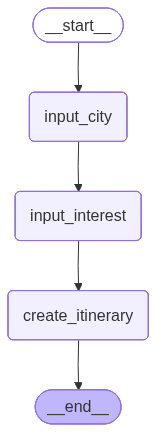

In [7]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

### Define the Function that runs the graph

In [8]:
def travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }
    for output in app.stream(state):
        pass

In [9]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: Amritsar
Please enter your interest for the trip to : Amritsar (comma-separted): 
Your Input: Golden Temple
Creating an itinerary for Amritsar based on interests : Golden Temple

Final Itinerary: 
Here's a brief, bulleted itinerary for your day trip to Amritsar, focusing on the Golden Temple:

* 8:00 AM: Arrive at the Golden Temple (Harmandir Sahib) and take a stroll around the complex
* 9:00 AM: Attend the morning prayer ceremony and take a dip in the holy sarovar (pool)
* 11:00 AM: Visit the Guru Ka Langar, a community kitchen that serves free meals to thousands of visitors
* 1:00 PM: Take a break for lunch at a nearby restaurant, trying some local Punjabi cuisine
* 2:30 PM: Explore the Central Sikh Museum, which showcases the history and culture of Sikhism
* 4:30 PM: Return to the Golden Temple for the evening prayer ceremony and witness the beautiful sunset
* 6:30 PM:

In [10]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages : Annotated[
        List[HumanMessage | AIMessage],
          "the messages in the conversation"
          ]
    city: str
    interests: List[str]
    itinerary: str

#Define the llm
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "GROQ_API_KEY",
    model_name = "llama-3.3-70b-versatile"
)

#Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip: ")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)]
        }

def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
        }
def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
    print("\nFinal Itinerary: ")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary" : response.content
    }

#Define the Gradio Application
def travel_planner(city_input: str, interests_input: str):
    print(f"City: {city_input}, Interests: {interests_input}\n")
    state = {
        "messages": [HumanMessage(content=f"Plan a trip to {city_input} with interests {interests_input}")],
        "city": city_input,
        "interests": [interest.strip() for interest in interests_input.split(",")],
        "itinerary": "",
    }

    # Generate the itinerary using the pre-filled state
    updated_state = create_itinerary(state)

    return updated_state["itinerary"]

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme= 'Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label= "Enter the city for your day trip"),
        gr.Textbox(label= "Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary", lines=10),
    title="HarryAI",
    description="""
    <div style="text-align:center; margin-top:5px;">
        <h3>Travel Itinerary Planner</h3>
        <p>
            Enter a city and your interests to generate a personalized day trip itinerary.
        </p>
    </div>
    """
)

#Launch the Gradio application
interface.launch()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://187882953143ce30af.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
